## Running notebook to test the developed functions

In [6]:
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

from src import preprocessing as pp
from src import contour_detection as cd
from src import symetry_analysis as sa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Size:  (238, 244, 3)


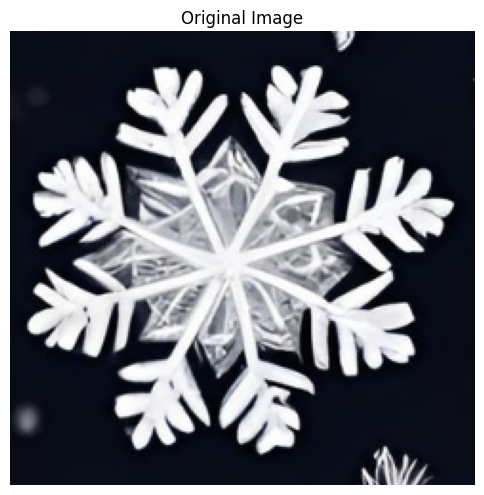

In [7]:
image_path = "data/024.jpg"
image = cv2.imread(image_path)

print("Size: ", image.shape)


plt.figure(figsize=(6, 6))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

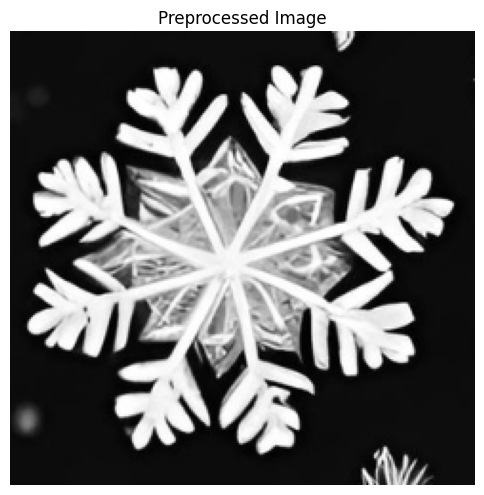

In [8]:

preprocessed_image = pp.preprocess_image(image)

plt.figure(figsize=(6, 6))
plt.title("Preprocessed Image")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

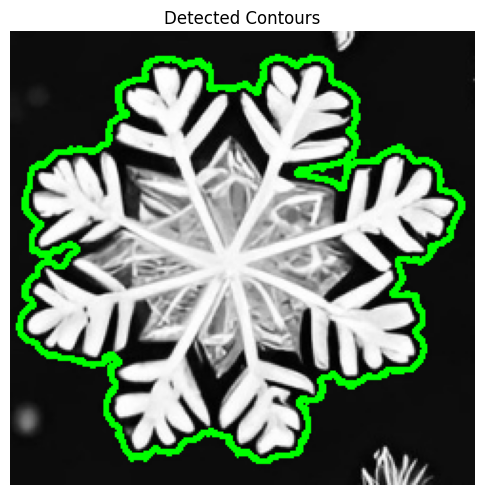

In [9]:
contour_image, contours = cd.detect_contours(preprocessed_image)

plt.figure(figsize=(6, 6))
plt.title("Detected Contours")
plt.imshow(contour_image)
plt.axis('off')
plt.show()

Axis Ratio: 0.9239
Circle/Rectangle Ratio: 0.7645
Average Rotational Symmetry: 0.4333
Final Symmetry Score: 0.7072


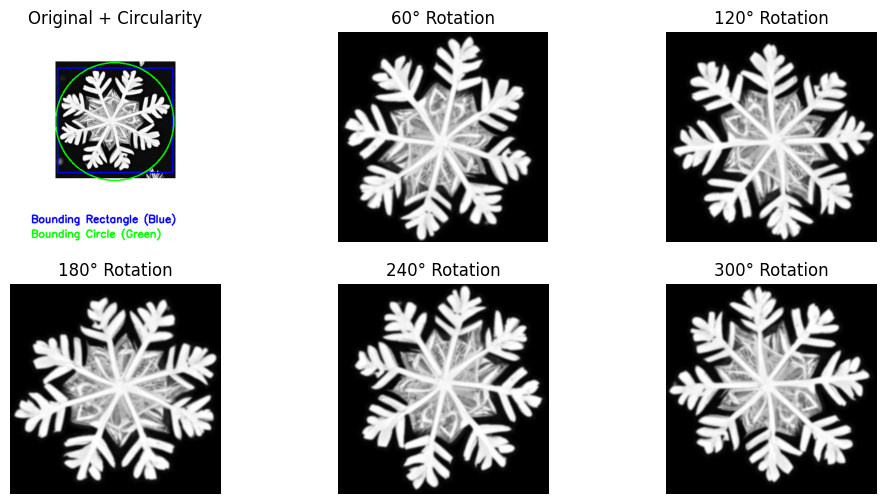

In [10]:
score = sa.analyze_symmetry(preprocessed_image, contours, vis=True)